# Binaural Sonification of Magnetometer Data
The purpose of this notebook is to generate binaural audio displays of data from ground magnetometers and THEMIS satellites. 

### Import packages:

In [1]:
# Importing packages
import pandas as pd
# smag = __import__('supermag-api')          # SuperMAG python API
# logon = 'kd8oxt'                              # SuperMAG ID

import plotly.express as px                # for mapping, mainly
import plotly.graph_objects as go          # for mapping, mainly

import matplotlib.pyplot as plt
import numpy as np

# import os
# # os.environ["CDF_LIB"] = library_directory
# # os.environ["CDF_LIB"] = "~/CDF/lib"          # default "~/CDF/lib"
# from spacepy import pycdf                  # for reading CDF files

# For pulling data from CDAweb:
from ai import cdas
import datetime
from matplotlib import pyplot as plt

# for progress viz:
from tqdm .auto import tqdm
# from tqdm import tqdm_notebook as tqdm
# from tqdm.notebook import trange, tqdm
from IPython.display import clear_output     # Used as a workaround to make tqdm not do silly things

import pickle

from collections import Counter   # for listing unique values

from scipy import signal

import os

# Import functions:

from magFunctions import *
from MagnetometerData2 import *
import matplotlib.dates as mdates

import IPython # for playing sounds in the notebook

import urllib.request # for pulling audifications and plots directly from CDAWeb
import wget # for downloading audifications

Install the `magSonify` package.

In [2]:
pip install git+https://github.com/marek-cottingham/magSonify/

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/marek-cottingham/magSonify/ to /tmp/pip-req-build-2ibqzi0s
  Running command git clone --filter=blob:none --quiet https://github.com/marek-cottingham/magSonify/ /tmp/pip-req-build-2ibqzi0s
  Resolved https://github.com/marek-cottingham/magSonify/ to commit 74edf69e6a89365d9a08935d58332bfcd8cfedc1
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Set parameters
First, we should establish the datetime range, stations, and cadence of the data that we want to examine with this approach. 

In [3]:
start = datetime.datetime(2016, 1, 25, 0, 0, 0) 
end = datetime.datetime(2016, 1, 25, 23, 0, 0)

Ground stations:

In [4]:
# Fetch station info from .csv and plot on a nice spinnable globe.
conjugate_stations = pd.read_csv('conjugate_stations.csv') # TODO: FIX THIS FILE!
conjugate_stations.Code

stations = pd.read_csv('20220726-04-17-supermag-stations.csv', sep = ',')   # edited version of this spreadsheet
stations = stations[stations.IAGA.isin(conjugate_stations.Code)] # Plot only the polar stations

# Plot stations:

fig = px.scatter_geo(stations, 
                     lat = stations.GEOLAT,
                     lon = stations.GEOLON,
                     color="OPERATOR", # size of markers, "pop" is one of the columns of gapminder
                     hover_name = "STATION-NAME", 
                     # text = "IAGA"
                     )
fig.update_geos(projection_type="orthographic")
fig.update_layout(height=600, margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


## Pull data of interest
Next, we pull the data of interest into pandas dataframes. Let's use SuperMAG's API.

In [5]:
smag = __import__('supermag-api')          # SuperMAG python API
logon = 'kd8oxt'                              # SuperMAG ID


# Example code for checking coverage from SuperMAG:
start=[2019,11,15,10,40,00] # alt: start='2019-11-15T10:40'
(status,stations) = smag.SuperMAGGetInventory(logon,start,3600)
# print(stations)   

# stations # uncomment to list stations

## Sonify data
There are two pieces of information we need to sort out in this step: what each sound source sounds like, and where it is.

### Direct audification
CDAWeb already incorporates a system for data audification. We start with a formatted URL, such as https://cdaweb.gsfc.nasa.gov/WS/cdasr/1/dataviews/sp_phys/datasets/THG_L2_MAG_PG0/data/20230419T000000Z,20230426T000000Z/thg_magh_pg0?format=audio, then read the XML it returns to find the file IDs.

We note from https://cdaweb.gsfc.nasa.gov/misc/NotesT.html#THG_L2_MAG_PG0 that some of the magnetometers log magnetic field, while others log *variation* in magnetic field.

For PG0:
Variation in Magnetic field B in HDZ vector components [thg_mag_pg0]
  - H - Local magnetic North component of B [thg_magh_pg0]
  - E - Local magnetic East component of B [thg_magd_pg0]
  - Z - Local vertical down component of B [thg_magz_pg0]

In [6]:
magname = "pg0"
parameter = 'Bx'

d = {'Bx':'h', 'By':'d','Bz':'z'}

url = "https://cdaweb.gsfc.nasa.gov/WS/cdasr/1/dataviews/sp_phys/datasets/"\
"THG_L2_MAG_" + magname.upper() +"/data/20230419T000000Z,20230426T000000Z/thg_mag" + d[parameter] +"_" + magname + \
"?format=audio"

with urllib.request.urlopen(url) as url:
    s = url.read()
    df = pd.read_xml(s)

df

Name   MimeType  \
0  https://cdaweb.gsfc.nasa.gov/tmp/wsxAQwvC/THG_...  audio/wav   

                  StartTime                   EndTime   Length  \
0  2023-04-19T00:00:00.000Z  2023-04-26T00:00:00.000Z  1209646   

               LastModified  
0  2024-08-23T05:10:50.872Z

Let's hear that audio!

In [7]:
wget.download(df.Name[0], out = 'output/') # download audio
IPython.display.Audio(df.Name[0])          # play audio in Jupyter notebook

100% [..........................................................................] 1209646 / 1209646

With a small tweak to the URL, we can also get a plot of the data that we're listening to.

In [8]:
magname = "pg0"
parameter = 'Bx'

url = "https://cdaweb.gsfc.nasa.gov/WS/cdasr/1/dataviews/sp_phys/datasets/"\
"THG_L2_MAG_" + magname.upper() +"/data/20230419T000000Z,20230426T000000Z/thg_mag" + d[parameter] +"_" + magname + \
"?format=gif"


with urllib.request.urlopen(url) as url:
    s = url.read()
    df = pd.read_xml(s)

df.Name[0]

from IPython.display import Image
Image(url=df.Name[0]) 

Let's pull audifications for all the stations we're interested in.

In [9]:
maglist_a = ['upn', 'umq', 'gdh', 'atu', 'skt', 'ghb']
maglist_b = ['pg0', 'pg1', 'pg2', 'pg3', 'pg4', 'pg5']
maglist = maglist_a+maglist_b

datestring = "20230419T000000Z,20230426T000000Z" # TODO: PULL THIS FROM DATETIMES


for magname in maglist:
    for parameter in ["Bx", "By", "Bz"]:
        try:
            filename = magname + '_' + parameter + '_' + datestring + '.wav'
            url = "https://cdaweb.gsfc.nasa.gov/WS/cdasr/1/dataviews/sp_phys/datasets/"\
            "THG_L2_MAG_" + magname.upper() +"/data/" + datestring+ "/thg_mag" + d[parameter] +"_" + magname + \
            "?format=audio"
            with urllib.request.urlopen(url) as url:
                s = url.read()
                df = pd.read_xml(s)
            wget.download(df.Name[0], out = 'output/'+filename)
            print('Saving ' + magname + ', ' + parameter)
            # IPython.display.Audio(filename)
        except Exception as e:
            print(e)
            continue

100% [..............................................................................] 20208 / 20208Saving upn, Bx
100% [..............................................................................] 20208 / 20208Saving upn, By
100% [..............................................................................] 20208 / 20208Saving upn, Bz
100% [..............................................................................] 20208 / 20208Saving umq, Bx
100% [..............................................................................] 20208 / 20208Saving umq, By
100% [..............................................................................] 20208 / 20208Saving umq, Bz
100% [..............................................................................] 20208 / 20208Saving gdh, Bx
100% [..............................................................................] 20208 / 20208Saving gdh, By
100% [..............................................................................] 20

### Wavelet sonification
We can also try sonifying the data using best practices for Pc5 waves. We'll be using the systems established in this paper: https://doi.org/10.3389/fspas.2022.877172 

In [10]:
# import context
# context.get()

from datetime import datetime
from magSonify.MagnetometerData import THEMISdata
from magSonify.Utilities import ensureFolder
import numpy as np

outputDir = "Audio_Processing_Example"

ensureFolder(outputDir)

mag = THEMISdata()

event2007_09_04 = (datetime(2007,9,4), datetime(2007,9,5))
event2008_12_07 = (datetime(2008,12,7), datetime(2008,12,10))
event2011_09_02 = (datetime(2011, 9, 2), datetime(2011, 9, 6))

# # Import the satellite data, specifying which themis satellite to use
# mag.importCDAS(
#     *event2008_12_07,
#     satellite='D'
# )

# # Interpolate the data to a consistent, know spacing (also cleans the data to remove duplicates)
# mag.interpolate(spacingInSeconds=3)

# mag.magneticField.constrainAbsoluteValue(400)

# # Compute the mean field, this is both to allow the mean field to be subtracted and for use later
# # in .convertToMeanFieldCoordinates(). Note that the exact attribute name: .meanField must be 
# # preserved in order for .convertToMeanFieldCoordinates() to work.
# mag.meanField = mag.magneticField.runningAverage(timeWindow=np.timedelta64(35,"m"))
# mag.magneticField = mag.magneticField - mag.meanField

# mag.fillLessThanRadius(4)
# mag.removeMagnetosheath()
# mag.convertToMeanFieldCoordinates()

# mag.magneticFieldMeanFieldCoordinates.fillNaN()

# # Extract each of the field components as a 1D data set, perform the time stretch and output as
# # audio
# com = mag.magneticFieldMeanFieldCoordinates.extractKey(0)
# com.phaseVocoderStretch(16)
# com.normalise()
# com.genMonoAudio(f"{outputDir}/Example of com x16 with phase vocoder.wav")

# pol = mag.magneticFieldMeanFieldCoordinates.extractKey(1)
# pol.phaseVocoderStretch(16)
# pol.normalise()
# pol.genMonoAudio(f"{outputDir}/Example of pol x16 with phase vocoder.wav")

# tor = mag.magneticFieldMeanFieldCoordinates.extractKey(2)
# tor.phaseVocoderStretch(16)
# tor.normalise()
# tor.genMonoAudio(f"{outputDir}/Example of tor x16 with phase vocoder.wav")

# # Disable the wavelet stretch output if it's taking too long
# # exit()

# com = mag.magneticFieldMeanFieldCoordinates.extractKey(0)
# com.waveletStretch(16,0.5,16)
# com.normalise()
# com.genMonoAudio(f"{outputDir}/Example of com x16 with wavelets.wav",sampleRate=44100//2)

# pol = mag.magneticFieldMeanFieldCoordinates.extractKey(1)
# pol.waveletStretch(16,0.5,16)
# pol.normalise()
# pol.genMonoAudio(f"{outputDir}/Example of pol x16 with wavelets.wav",sampleRate=44100//2)

# tor = mag.magneticFieldMeanFieldCoordinates.extractKey(2)
# tor.waveletStretch(16,0.5,16)
# tor.normalise()
# tor.genMonoAudio(f"{outputDir}/Example of tor x16 with wavelets.wav",sampleRate=44100//2)

In [11]:
# # import IPython
# IPython.display.Audio(outputDir + "/" +"Example of pol x16 with phase vocoder.wav")

### Convert station coordinates to spatial coordinates in audio environment
There are multiple ways that we can do this. One way is to put the listener at the center of the Earth and situate the stations around them. 

However we set it up, there are two things we should ensure:
- The audio coordinates should be a direct transform from the physical coordinates of the stations;
- It should be possible for the audio coordinates to move over time, in order to accommodate data from satellites.

## Binauralize audio
Next, we'll use spaudiopy (https://github.com/chris-hld/spaudiopy) to put the audio we computed at the coordinates we computed, and produce an audio file for it.

/mnt/c/Users/kvc2/Documents/Space Science Institute/spaudiopy/spaudiopy/utils.py:52: RuntimeWarning: invalid value encountered in divide
  zen = np.arccos(z / r) if not steady_zen else \


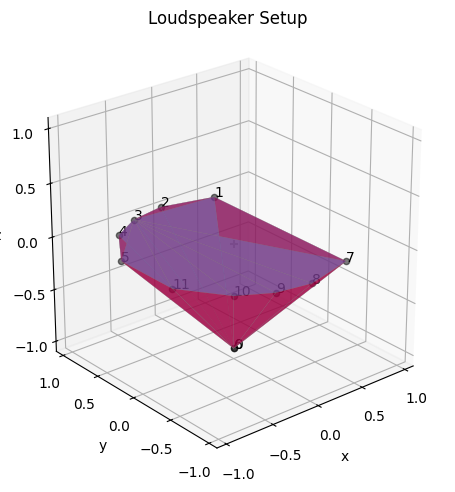

In [1]:
import numpy as np
import spaudiopy as spa

# sampling frequency
fs = 48000
# length in s
l = 0.5
# define a mono input signal (only pulsed noise here)
sig_in = spa.process.pulsed_noise(l, l, fs, reps=3) # test signal
# sig_in = tor.data[0]

# load a loudspeaker layout
# ls_layout = spa.io.load_layout('../postdoc/layouts/Aalto_subset_C.json')
ls_layout = spa.io.load_layout('ls_layouts/ConjMags.json')
ls_layout.show()

# # define auralization (front)
# src_coords = [1, 0, 10]
# # define decoding, using vbap as simple example
# ls_gains = spa.decoder.vbap(src_coords, ls_layout)
# ls_sigs = ls_layout.loudspeaker_signals(ls_gains, sig_in)

# # binaural simulation of this setup
# s_left, s_right = ls_layout.binauralize(ls_sigs, fs)

# # for convenience we could now make a signal object and listen to it
# # foo = spa.sig.MultiSignal([s_left, s_right], fs=fs)
# IPython.display.Audio([s_left, s_right],rate=fs)

In [13]:
ls_sigs

array([[-0.00000000e+00, -6.32026911e-07, -4.50533852e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00, -1.52886017e-07, -1.08983217e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  2.37940995e-23,  1.69613779e-22, ...,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00],
       ...,
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [14]:
# define auralization (front)
src_coords = [1, 0, 0]
# define decoding, using vbap as simple example
ls_gains = spa.decoder.vbap(src_coords, ls_layout)
ls_sigs = ls_layout.loudspeaker_signals(ls_gains, sig_in)

# binaural simulation of this setup
s_left, s_right = ls_layout.binauralize(ls_sigs, fs)

In [15]:
# TESTING - Let's try multiple simultaneous sounds. In this case, I'll add a different sonification of the same sound to the signal created above.
# define auralization (front)
src2_coords = [0, 10, 0]
# define decoding, using vbap as simple example
ls_gains2 = spa.decoder.vbap(src2_coords, ls_layout)
ls_sigs2 = ls_layout.loudspeaker_signals(ls_gains2, sig_in)#com.data[0])

# binaural simulation of this setup
s_left2, s_right2 = ls_layout.binauralize(ls_sigs2, fs)

# for convenience we could now make a signal object and listen to it
# foo = spa.sig.MultiSignal([s_left, s_right], fs=fs)


IPython.display.Audio([s_left+s_left2, s_right+s_right2],rate=fs)

Now we create a new class, based on the THEMIS class already included in magSonify, to pull data for ground magnetometers. (Thanks go to Aidan Montare for her help with this part!)

In [16]:
from magSonify import DataSet_3D
from magSonify.TimeSeries import generateTimeSeries
# pd.timeSeries = pd.Series   

class GroundData(MagnetometerData):
    def importCDAS(self, startDatetime, endDatetime, magname='pg1') -> None:
        self._importAsync(
            (
                self._importCdasMagneticField,
            ),
            startDatetime,
            endDatetime,
            magname)
    
    def _importCdasMagneticField(self, startDatetime, endDatetime, magname) -> None:
        cdasArgs = (
            'sp_phys',
            f'THG_L2_MAG_{magname.upper()}',
            startDatetime,
            endDatetime,
            [f'thg_mag_{magname.lower()}']
        )
        timeSeriesKey = "UT"
        targetKeys = {
            0: 'MAGNETIC_NORTH_-_H',
            1: 'MAGNETIC_EAST_-_E',
            2: 'VERTICAL_DOWN_-_Z',
        }
        self.magneticField = self._importCdasItemWithExceptions(
            cdasArgs,timeSeriesKey,targetKeys,DataSet_3D
        )

    def interpolate(self,spacingInSeconds=60) -> None:
        """Interpolates data sets :attr:`magneticField`, :attr:`position` and 
        :attr:`peemIdentifyMagnetosheath` to the specified spacing, if they are not None.

        A default spacing of 3s is chossen for THEMIS data. This is slightly smaller than the mean
        sample spacing in the raw magnetometer data of ~3.17 s. Using a consistent value aids in 
        establishing the correspondence between frequencies in sonified audio and the raw data.
        
        For ground mags, I've changed this to 60s, since that's the slower pace used by the 
        systems in the Arctic.
        """
        refTimeSeries = generateTimeSeries(
            self.magneticField.timeSeries.getStart(),
            self.magneticField.timeSeries.getEnd(),
            spacing=np.timedelta64(spacingInSeconds,'s')
        )
        self._interpolateReference(refTimeSeries)

    # def convertToMeanFieldCoordinates(self) -> None:
    #     """ Converts the magnetic field data in :attr:`magneticField` to mean field coordinates,
    #     saving the output in :attr:`magneticFieldMeanFieldCoordinates`.
        
    #     .. warning::

    #         :attr:`meanField` must be specified and contain a 3D dataset with the mean 
    #         magnetic field.

    #         :attr:`magneticField` must be specified
    #     """
    #     assert(self.position.timeSeries == self.magneticField.timeSeries)
    #     assert(self.magneticField.timeSeries == self.meanField.timeSeries)

    #     fieldUnitVector = self.meanField.copy()
    #     fieldUnitVector.makeUnitVector()
    #     earthUnitVector = -(self.position.copy())
    #     earthUnitVector.makeUnitVector()

    #     polUnitVector = fieldUnitVector.cross(earthUnitVector)
    #     polUnitVector.makeUnitVector()
    #     torUnitVector = fieldUnitVector.cross(polUnitVector)
    #     torUnitVector.makeUnitVector()

    #     self.magneticFieldMeanFieldCoordinates = self.magneticField.coordinateTransform(
    #         fieldUnitVector,
    #         polUnitVector,
    #         torUnitVector
    #     )

    def defaultProcessing(self):
        self.interpolate()
        #self.convertToMeanFieldCoordinates() # <-- creates attr magneticFieldMeanFieldCoordinates
        #self.magneticFieldMeanFieldCoordinates.fillNaN()

Applying that new class to sonify data from PG1:

In [17]:
magname = 'pg1'
# start = datetime(2016, 6, 28, 5, 18, 0)
# end = datetime(2016, 6, 29, 5, 58, 0)
start = datetime(2023, 4, 23, 0, 0, 0)
end = datetime(2023, 4, 24, 0, 0, 0)
g = GroundData()
g.importCDAS(start, end, magname)
# g.magneticField
# g.defaultProcessing()
# g_pol1 = g.magneticField.extractKey(2)
# # g_pol1.phaseVocoderStretch(320)
# g_pol1.waveletStretch(16)
# # g_pol.normalise()
# filename = magname+"_" + start.strftime("%Y-%m-%d-%H-%M-%S") + end.strftime("%Y-%m-%d-%H-%M-%S") + ".wav"
# g_pol1.genMonoAudio(filename)
# g_pol1.data

IPython.display.Audio(filename)

ValueError: rate must be specified when data is a numpy array or list of audio samples.

In [ ]:
maglist_a = ['upn', 'umq', 'gdh', 'atu', 'skt', 'ghb']
maglist_b = ['pg0', 'pg1', 'pg2', 'pg3', 'pg4', 'pg5']
maglist = maglist_a+maglist_b


for idx in range(len(maglist)):
    try:
        magname = maglist[idx]
        # start = datetime(2016, 6, 28, 5, 18, 0)
        # end = datetime(2016, 6, 29, 5, 58, 0)
        start = datetime(2023, 4, 18, 0, 0, 0)
        end = datetime(2023, 4, 26, 0, 0, 0)
        g = GroundData()
        g.importCDAS(start, end, magname)
        g.magneticField
        g.defaultProcessing()
        g_pol2 = g.magneticField.extractKey(2)
        # g_pol2.phaseVocoderStretch(16)
        g_pol2.waveletStretch(32)
        filename = 'output/'+ magname+"_" + start.strftime("%Y-%m-%d-%H-%M-%S") + end.strftime("%Y-%m-%d-%H-%M-%S") + ".wav"
        # g_pol.normalise()
        g_pol2.genMonoAudio(filename)
        # g_pol2.data
        print('Saving ' + filename)
        # IPython.display.Audio(filename)
    except Exception as e:
        print(e)
        continue

In [ ]:
# TESTING - Let's try multiple simultaneous sounds. In this case, I'll add 
# a different sonification of the same sound to the signal created above.

# define auralization (front)
pg1_coords = [10, 10, 0]
# define decoding, using vbap as simple example
pg1_gains = spa.decoder.vbap(pg1_coords, ls_layout)
pg1_sigs = ls_layout.loudspeaker_signals(pg1_gains, g_pol1.data[0])

# binaural simulation of this setup
s_left2, s_right = ls_layout.binauralize(pg1_sigs, fs)

# for convenience we could now make a signal object and listen to it
# foo = spa.sig.MultiSignal([s_left, s_right], fs=fs)

# SAME THING FOR NORTHERN HEMISPHERE
umq_coords = [-10, -10, 0]
# define decoding, using vbap as simple example
umq_gains = spa.decoder.vbap(umq_coords, ls_layout)
umq_sigs = ls_layout.loudspeaker_signals(umq_gains, g_pol2.data[0])

# binaural simulation of this setup
s_left2, s_right2 = ls_layout.binauralize(umq_sigs, fs)


IPython.display.Audio([s_left+s_left2, s_right+s_right2],rate=fs)
# IPython.display.Audio([s_left, s_right],rate=fs)
# IPython.display.Audio([s_left2, s_right2],rate=fs)